<a href="https://colab.research.google.com/github/mitresthen/phys117_2021/blob/main/SphaleronsVBlackHoles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sphalerons Black holes

##Imports, mapping, dataset

###Imports

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [8]:
import math
from google.colab import drive
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.ticker as ticker
import statistics

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

import h5py
import pandas as pd
import seaborn as sn
from PIL import Image
from sklearn.metrics import confusion_matrix

matplotlib.rc('image', cmap='YlGnBu')



###Mapping

In [9]:
colmapper = {
    "typ" : 0,
    "eta" : 1,
    "phi" : 2,
    "pt" : 3,
    "jmass" : 4,
    "ntrk" : 5,
    "btag" : 6,
    "hadem" : 7,
}

objectMapping = {
    0 : "Photon",
    1 : "Electron",
    2 : "Muon",
    3 : "Tau",
    4 : "Jet",
    6 : "MTE"
}

inclusiveObjectMapping = {
    0 : "Photon",
    1 : "Electron",
    2 : "Muon",
    3 : "Tau",
    4 : "Jet",
    6 : "MTE",
    7 : "Total"
}

###Datasets

In [10]:
  # class DataSet:              #
  # data = []
  # def __init__(self,path):
  #   self.path = path
  #   self.data = self.__readData()
  #   self.fileName = Path(self.path).stem
  # def __readData(self):
  #   matrices = []
  #   with open(self.path, 'r') as file:
  #     matrix = []
  #     for line in file:
  #       elements = line.split()
  #       if elements[0] == "#":
  #         continue
  #       if elements[0] == "0":
  #         if len(matrix) != 0:
  #           matrices.append(matrix)
  #           matrix = []
  #         continue
  #       vector = []
  #       objType = int(elements[1])
  #       vector.append(objType)
  #       for i in range (2, 10):
  #         elem = float(elements[i])
  #         vector.append(elem)
  #       if vector[3] > 15:
  #         matrix.append(vector)
  #     if len(matrix) != 0:
  #      matrices.append(matrix)
  #   return matrices



In [11]:
class DataSet:                              #Filters and counts number of objects rejected.
  data = []
  def __init__(self,path):
    self.path = path
    self.data = self.__readData()
    self.fileName = Path(self.path).stem
  def __readData(self):
      matrices = []
      countUnder15 = 0
      countUnder20 = 0
      with open(self.path, 'r') as file:
        matrix = []
        for line in file:
          elements = line.split()
          if elements[0] == "#":
            continue
          if elements[0] == "0":
            if len(matrix) != 0:
              matrices.append(matrix)
              matrix = []
            continue
          vector = []
          objType = int(elements[1])
          vector.append(objType)
          for i in range (2, 10):
            elem = float(elements[i])
            vector.append(elem)
          if vector[0] == 0 or vector[0] == 1 or vector[0] == 2:
            if vector[3] > 15:
              matrix.append(vector)
            elif vector[3] <= 15:
              countUnder15 += 1    #count for objects rejected of type photon, electron, muon.
          elif vector[0] == 3 or vector[0] == 4:    
            if vector[3] > 20:
              matrix.append(vector)
            elif vector[3] <= 20:
              countUnder20 += 1   #count for objects rejected of type Tau, Jet
          else : matrix.append(vector)
        if len(matrix) != 0:
          matrices.append(matrix)
      print(f'{Path(self.path).stem} count of rejected Photon, Electron, Muon: {countUnder15}')   
      print(f'{Path(self.path).stem} count of rejected Tau, Jet: {countUnder20}')   
      return matrices

In [12]:
BlackMaxOutputPath = "/content/gdrive/MyDrive/Colab Notebooks/Phys117Data/BlackMaxOutputFirstRun/BlackMaxOutputFirstRun.lhco"
BlackMaxOutput2Path = "/content/gdrive/MyDrive/Colab Notebooks/Phys117Data/BlackMaxOutputFirstRun/BlackMaxOutputFirstRun2.lhco"
Sph13Path = "/content/gdrive/MyDrive/Colab Notebooks/Phys117Data/spharelon_events_for_ML/PP13-Sphaleron-THR9-FRZ15-NB33-71-NSUBP5.lhco"
paths = [
  BlackMaxOutputPath,
  BlackMaxOutput2Path,
  Sph13Path
  ]
dataSets = []

for path in paths:
  dataset = DataSet(path)
  dataSets.append(dataset)
  print(len(dataset.data))
print(dataSets)


BlackMaxOutputFirstRun count of rejected Photon, Electron, Muon: 95
BlackMaxOutputFirstRun count of rejected Tau, Jet: 0
10000
BlackMaxOutputFirstRun2 count of rejected Photon, Electron, Muon: 89
BlackMaxOutputFirstRun2 count of rejected Tau, Jet: 0
10000
PP13-Sphaleron-THR9-FRZ15-NB33-71-NSUBP5 count of rejected Photon, Electron, Muon: 78
PP13-Sphaleron-THR9-FRZ15-NB33-71-NSUBP5 count of rejected Tau, Jet: 0
1000
[<__main__.DataSet object at 0x7f6281ca49d0>, <__main__.DataSet object at 0x7f627f59b050>, <__main__.DataSet object at 0x7f627ce6e0d0>]


# New Section

In [13]:

def getObjectCounts(matrix):
  maxObjects = 0
  for matrice in matrix:
    if(len(matrice) > maxObjects):
      maxObjects = len(matrice)
  counts = [0] * (maxObjects+1)
  for matrice in matrix:
      counts[len(matrice)] += 1
  return counts


In [14]:
def getSpecificObjectCounts(matrix, objectType):
  maxObjects = 0
  for event in matrix:
    sumOfThisObject = 0
    for obj in event:
      if obj[0] == int(objectType):
        sumOfThisObject += 1
    if sumOfThisObject > maxObjects:
      maxObjects = sumOfThisObject
  #print(f'Found event with max {maxObjects} of type {objectMapping[objectType]}')
  counts = [0] * (maxObjects+1)
  for event in matrix:
    sumOfThisObject = 0
    for obj in event:
      if obj[0] == int(objectType):
        sumOfThisObject += 1
    counts[sumOfThisObject] += 1
  return counts


In [15]:
def plotObjectDistribution(binnedObjects, title):
  xVals = list(range(0,len(binnedObjects)))
  if(len(xVals) != len(binnedObjects)):
    print("Size different")
  plt.bar(xVals, binnedObjects)
  plt.title(title)
  plt.show()

In [16]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True, alignment="center"):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    final_width = bar_width * single_width

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = 0
        if alignment == "center":
          x_offset += (i - n_bars / 2) * final_width  + final_width / 2
        elif alignment == "right":
            x_offset += i*final_width + final_width / 2
        
        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=final_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(), bbox_to_anchor=(1, 1.4))


def comparativePlot(binnedObjectSets, title):
  fig, ax = plt.subplots()
  dataDict = {}
  for filename, binnedObjects in binnedObjectSets:
    dataDict[filename] = binnedObjects

  bar_plot(ax, dataDict, total_width=.8, single_width=.9)
  plt.title(title)
  plt.xlabel('nr of particles per event')
  plt.ylabel('Probability')
  plt.show()

In [17]:
def normalizeObjectCounts(objectCounts):
  nrOfObjects = sum(objectCounts)
  return [i/nrOfObjects for i in objectCounts]

def normalizeObjectCounts2d(objectCounts2d):
  normalizedObjectCounts2d = []
  for objectCounts in objectCounts2d:
    normalizedObjectCounts = normalizeObjectCounts(objectCounts)
    normalizedObjectCounts2d.append(normalizedObjectCounts)
  return normalizedObjectCounts2d
    
  

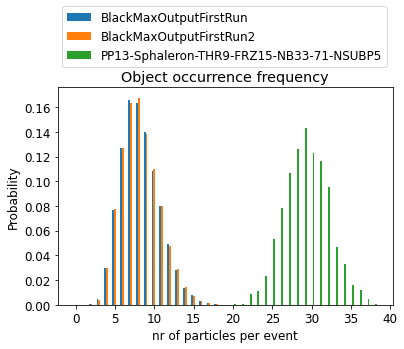

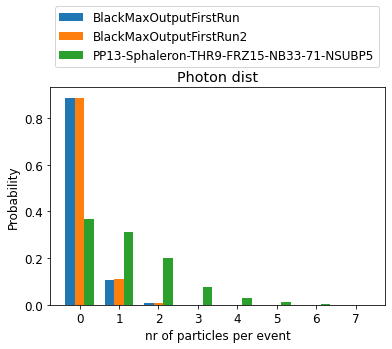

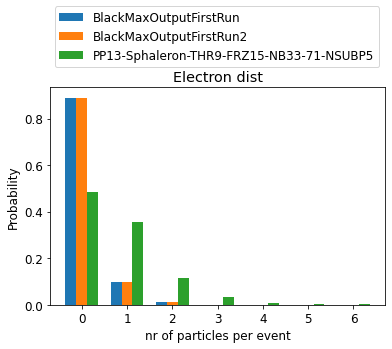

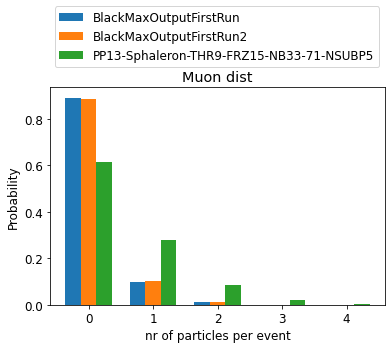

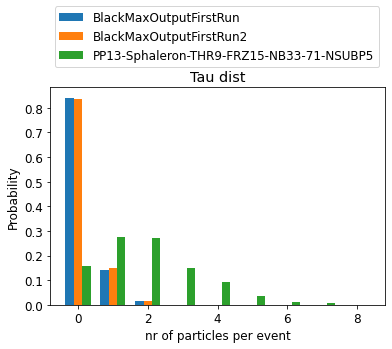

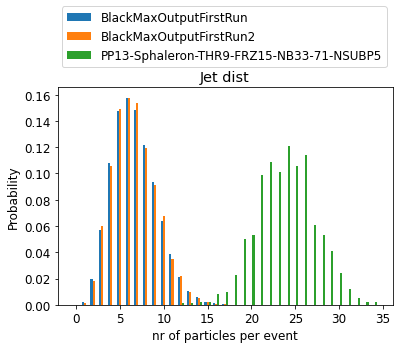

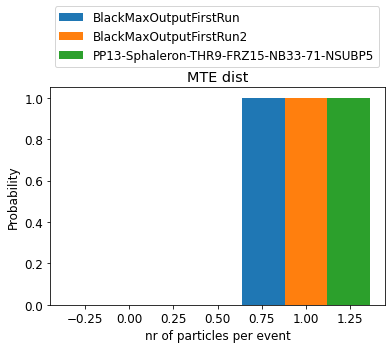

In [18]:
def plotComparativeTotalObjectDistribution():
  objectCounts=[]
  for dataSet in dataSets:
    objectCounts.append((dataSet.fileName, normalizeObjectCounts(getObjectCounts(dataSet.data))))
  comparativePlot(objectCounts, "Object occurrence frequency")

def plotComparativeSpecificObjectDistribution():
    for objectType in objectMapping:
        specificCounts = []
        for dataSet in dataSets:
          specificCounts.append((dataSet.fileName, normalizeObjectCounts(getSpecificObjectCounts(dataSet.data, objectType))))
        comparativePlot(specificCounts, f'{objectMapping[objectType]} dist')

plotComparativeTotalObjectDistribution()
plotComparativeSpecificObjectDistribution()

In [19]:
noEmptyObjects = False         #Removes datapoints with PT = 0.
useSumMultiplicity = False     #If True, energy of each objecttype is summed per event.
normalizePTPlot = True        #Probabillity density plot.

def getSpecificObjectEnergy(matrices,objectType):
  pTListSpecific = []
  for matrix in matrices:
    for obj in matrix:
      if obj[0] == int(objectType):
        pTListSpecific.append(float(obj[3]))
  return pTListSpecific 

def getTotalObjectEnergyPerEvent(matrices, objectType):   #sums energy for objects of same type in an event. Gives lots of 0 values.
  pTTotal = []
  for matrix in matrices:
    pTForObjType = 0
    for obj in matrix:
      if obj[0] == int(objectType):
        pTForObjType += float(obj[3])
    if noEmptyObjects == True and pTForObjType != 0:
      pTTotal.append(pTForObjType)
    elif noEmptyObjects == False:
      pTTotal.append
    else: continue
  return pTTotal

def sumPT(matrices):
  pTListTotal = []
  for matrix in matrices:
    pT = 0
    for obj in matrix:
      pT += float(obj[3])
    pTListTotal.append(pT) 
  return pTListTotal

def plotSumPT(pTList,fileName):
  maxpT = max(pTList)
  title = fileName + " sum of pT"
  print("The highest transverse energy of a ", fileName, " event was: ", maxpT, "[GeV/c].")
  plt.hist(pTList, bins=20)
  plt.title(title)
  plt.xlabel("energy of events  [GeV]")
  plt.ylabel("number of events")
  plt.show()
  plt.close()

def plotSpecificpT(pTList,objectType,fileName):
  maxpT = max(pTList)
  title = f"{fileName} {objectMapping[objectType]} sum of pT"
  print(f"The highest transverse energy of a {objectMapping[objectType]} was: {maxpT} [GeV/c].")
  plt.hist(pTList, bins=20)
  plt.title(title)
  plt.xlabel("energy of objects  [GeV]")
  plt.ylabel("number of objects")
  plt.show()
  plt.close()

def plotBaseEnergy(dataSet):
  for objectType in objectMapping:
    pTListSpecific = getSpecificObjectEnergy(dataSet.data, objectType)
    plotSpecificpT(pTListSpecific, objectType, dataSet.fileName)

Plot av MTE til total PT ratio:
For hver event:
1. finn total pt inkludert mte sin pt
2. finn mte for event
3. finn ratio = mte/totalPt og lagre slik at vi vet hvilken ratio som hører til hvilken event.
4. lag histogram

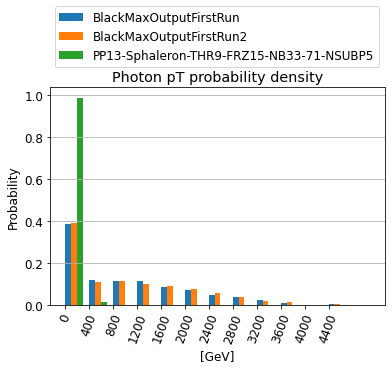

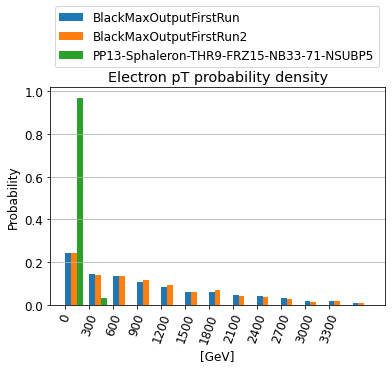

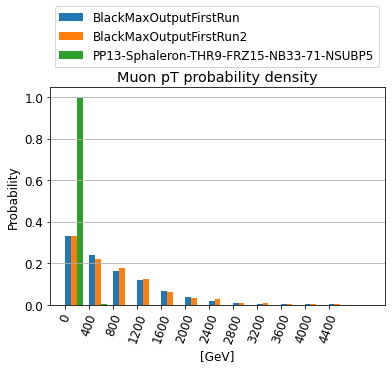

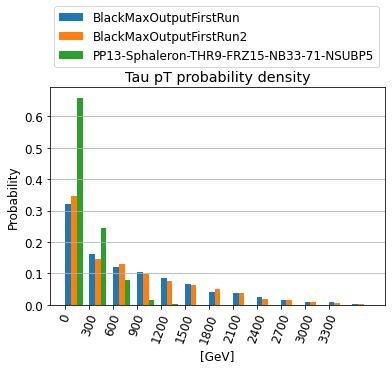

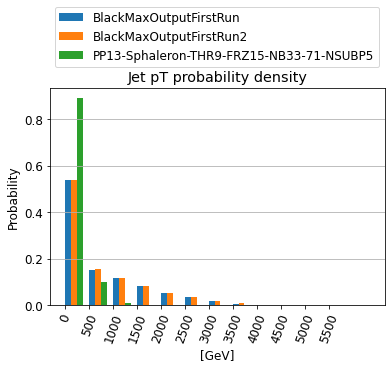

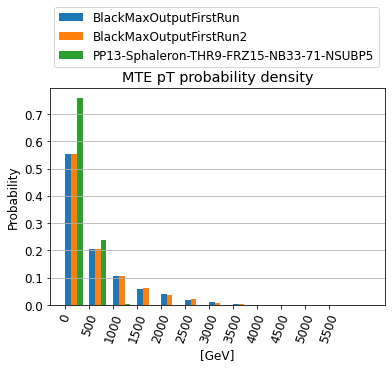

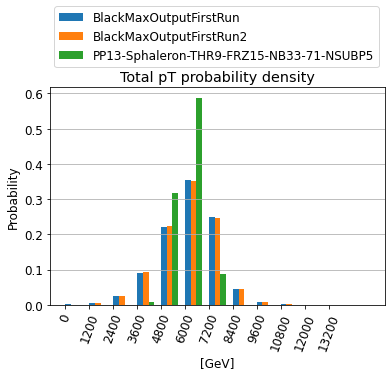

In [20]:
def mapPT():
  mapPT = {}
  for dataSet in dataSets:
    for obj in inclusiveObjectMapping:
      if obj != 7:
        if useSumMultiplicity == True:
          mapPT[dataSet.fileName, obj] = getTotalObjectEnergyPerEvent(dataSet.data, obj)
        elif useSumMultiplicity == False:
          mapPT[dataSet.fileName, obj] = getSpecificObjectEnergy(dataSet.data, obj)
      elif obj == 7:
        mapPT[dataSet.fileName, obj] = sumPT(dataSet.data)
  return mapPT

def makeBins(mapPT=mapPT(), binNr=13):
  mapBins = {}
  mapBinSize = {}
  for objectType in inclusiveObjectMapping:
    maxXVal = 0
    minXVal = 0
    bins = []
    for dataSet in dataSets:
      currentMaxXVal = max(mapPT[dataSet.fileName, objectType])
      if maxXVal < currentMaxXVal:
        maxXVal = currentMaxXVal
    currentBinSize = (maxXVal - minXVal)/binNr
    binSize = round(currentBinSize, -2)
    mapBinSize[objectType] = binSize
    for i in range(binNr):
      bins.append(i*binSize)
    mapBins[objectType] = bins
  return mapBins, binNr, mapBinSize

def binEnergyCount(mapPT=mapPT(), binsData=makeBins()):
  mapBins, binNr, mapBinSize = binsData
  mapBinnedEnergyCount = {}
  for objectType in inclusiveObjectMapping:
    binSize = mapBinSize[objectType]
    for dataSet in dataSets:
      binnedEnergyCount = [0]*binNr
      lowValueCount = 0
      for i, binXVal in enumerate(mapBins[objectType]):
        for value in mapPT[dataSet.fileName, objectType]:
          if (value >= binXVal) and (value < (binXVal+binSize)) and (i <= binNr-1):
            binnedEnergyCount[i] += 1
          if (value >= 0) and (value < 1):
            lowValueCount += 1
      #print(f'{dataSet.fileName}, {objectType}, {lowValueCount} objects of pt less than 1')
      mapBinnedEnergyCount[dataSet.fileName, objectType] = binnedEnergyCount

  return mapBinnedEnergyCount

# def combineBins(mapBinnedEnergyCount=binEnergyCount()):
#   combinedEnergyMap = {}
#   for objectType in inclusiveObjectMapping:
#     combinedEnergySet = []
#     for dataSet in dataSets:
#       combinedEnergySet.append(mapBinnedEnergyCount[dataSet.fileName, objectType])
#     combinedEnergyMap[objectType] = combinedEnergySet
#   return combinedEnergyMap


def comparativePTPlot(binnedObjectSets, title, objectType, binInfo):
  fig, ax = plt.subplots()
  mapBins, binNr, binSize = binInfo
  ticks = []
  labels = []
  for i in range(binNr-1):
    a = int(i)
    ticks.append(a)
    labels.append(int((a)*binSize[objectType]))
  dataDict = {}
  for filename, binnedObjects in binnedObjectSets:
    dataDict[filename] = binnedObjects

  bar_plot(ax, dataDict, total_width=.8, single_width=.9, alignment="right")
  plt.title(title)
  plt.xticks(ticks=ticks, labels=labels, rotation=70)
  if normalizePTPlot == True:
    plt.ylabel(f'Probability')
  if normalizePTPlot == False:
    plt.ylabel(f'counts') 
  #plt.xlabel(f'Binsize: {int(binSize[objectType])}[GeV]')
  plt.xlabel(f'[GeV]')
  plt.grid(axis='y')
  plt.show()


def plotComparativeSpecificObjectEnergyDistribution(binEnergyCount):
    for objectType in inclusiveObjectMapping:
      specificCounts = []     
      for dataSet in dataSets:
        if normalizePTPlot == True:
          NormalizedObjectCounts = normalizeObjectCounts(binEnergyCount[dataSet.fileName, objectType])
          specificCounts.append((dataSet.fileName, NormalizedObjectCounts))
          norm = 'pT probability density'
        if normalizePTPlot == False:
          norm = 'dist'
          specificCounts.append((dataSet.fileName, binEnergyCount[dataSet.fileName, objectType]))
        
      title = f'{inclusiveObjectMapping[objectType]} {norm}'
      binInfo = makeBins()
      comparativePTPlot(specificCounts, title, objectType, binInfo)

plotComparativeSpecificObjectEnergyDistribution(binEnergyCount())

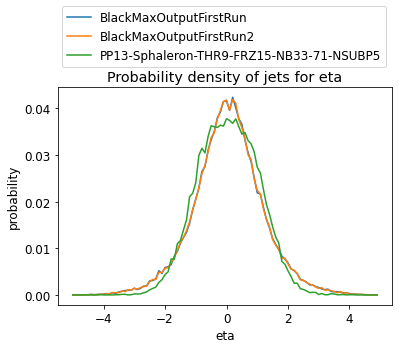

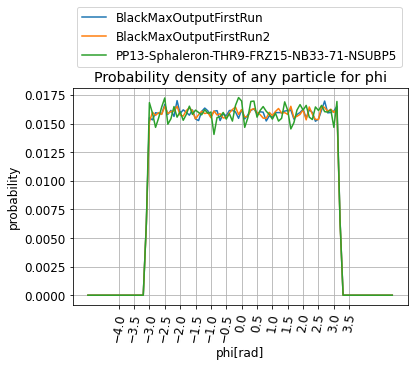

In [21]:
#Eta distribution of jets

def getAllEtas(dataSet):
  objectType = 4
  etaValues = []
  for matrix in dataSet.data:
    for obj in matrix:
      if obj[0] == objectType:
        etaValues.append(obj[colmapper["eta"]])
  return etaValues

def plotAllEtaNormalizedDist():
  etas = {} 
  bins = np.arange(-5.0, 5.0, 0.1)
  for dataSet in dataSets:
    hist, bins = np.histogram(getAllEtas(dataSet), bins)
    normalizedHist = normalizeObjectCounts(hist)
    plt.plot(bins, np.pad(normalizedHist, (1,0)), label = dataSet.fileName)
    plt.title('Probability density of jets for eta')
    plt.xlabel('eta')
    plt.ylabel('probability')

  #plt.legend(loc="upper left")
  plt.legend(bbox_to_anchor=(1, 1.4))
  plt.show()

#Phi distribution

def getAllPhis(dataSet):
  phiValues = []
  for matrix in dataSet.data:
    for obj in matrix:
        phiValues.append(obj[colmapper["phi"]])
  return phiValues

def plotAllPhiNormalizedDist():
  etas = {} 
  bins = np.arange(-5.0, 5.0, 0.1)
  for dataSet in dataSets:
    hist, bins = np.histogram(getAllPhis(dataSet), bins)
    normalizedHist = normalizeObjectCounts(hist)
    plt.plot(bins, np.pad(normalizedHist, (1,0)), label = dataSet.fileName)
    plt.grid()
    plt.xticks(np.arange(-4,4,0.5), rotation = 80)
    plt.xlabel('phi[rad]')
    plt.ylabel('probability')
    plt.title('Probability density of any particle for phi')
  plt.legend(bbox_to_anchor=(1, 1.4))
  plt.show()

plotAllEtaNormalizedDist()
plotAllPhiNormalizedDist()

In [22]:
def standardDeviance2D(etaValues):
  std = []
  for etaVals in etaValues:
    std.append(statistics.stdev(etaVals))
  return std

def mean2D(etaValues):
  mean = []
  for etaVals in etaValues:
    mean.append(statistics.mean(etaVals))
  return mean

In [23]:
# for dataset in dataSets:
  # pTListTotal = sumPT(dataset.data)
  # plotSumPT(pTListTotal, dataset.fileName)
  # plotBaseEnergy(dataset)

per dataset:
  1. summer energi per objekt-type & plot i ett image per objekt-type
  2. finn maxval per objekt-type
  3. normaliser alle imager basert på maxval for sin objekt-type
  4. slå sammen imager for electron, muon og jets per event

In [24]:
def normalizeEnergyImages(objTypeToMaxVal, imageSet):
  normalizedImages = {}
  for imageKey in imageSet:                  
    filename, eventNr, objectType = imageKey
    image = imageSet[imageKey]
    currMaxVal = objTypeToMaxVal[objectType]
    for coord in image:
      x, y = coord
      image[(x, y)] = int(255*(image[(x, y)]/currMaxVal))
    normalizedImages[(imageKey)] = image
  return normalizedImages

In [25]:
def createEtaPhiBinnedImages(dataSet, 
                             imageHeight, 
                             imageWidth, 
                             maxEta, 
                             minEta, 
                             maxPhi, 
                             minPhi):
  objTypeToMaxVal = {}
  images = {}
  scalingFactorEta = imageWidth/(maxEta-minEta)
  scalingFactorPhi = imageHeight/(maxPhi-minPhi)
  for objectType in objectMapping:
    objTypeToMaxVal[objectType] = 0
  for i, event in enumerate(dataSet.data):
    totalPt = 0
    mte = 0

    for objectType in objectMapping:
      image = {}
      for obj in event:
        if int(obj[colmapper["typ"]]) != int(objectType):
          continue
        eta = np.clip(obj[colmapper["eta"]], minEta, maxEta) + abs(minEta)
        convertedEta = max(0, round(eta*scalingFactorEta)-1) 

        phi = obj[colmapper["phi"]] + abs(minPhi)
        convertedPhi = max(0, round(phi*scalingFactorPhi)-1)

        pT = obj[colmapper["pt"]]
        energyP = pT*math.cosh(obj[colmapper["eta"]])

        image[(convertedEta, convertedPhi)] = energyP + image.get((convertedEta, convertedPhi), 0) 

        objTypeToMaxVal[objectType] = max(objTypeToMaxVal[objectType], image[(convertedEta, convertedPhi)] )

      images[(dataSet.fileName, i, objectType)] = image
  return (objTypeToMaxVal, images)

In [26]:
def fillBlanksInImage(sparseImage, height, width):
  newImage = [[ 0 for x in range(0,height)] for y in range(0,width)]
  for coord in sparseImage:
    x, y = coord
    newImage[x][y] = sparseImage[coord]
  return newImage

In [27]:
def mergeImages(height, width, redImage = {}, greenImage = {}, blueImage = {}):
    newImage = [[ (0, 0, 0) for x in range(0,height)] for y in range(0,width)]
    for coord in redImage:
      x, y = coord
      newImage[x][y] += (redImage[coord], 0, 0)
    for coord in greenImage:
      x, y = coord
      newImage[x][y] += (0, greenImage[coord], 0)
    for coord in blueImage:
      x, y = coord
      newImage[x][y] += (0, 0, blueImage[coord])
    return newImage

In [28]:
def mergeImageSparse(redImage, greenImage, blueImage):
  newImage = {}
  for coord in redImage:
    newImage[coord] = tuple(map(lambda x, y: x + y, newImage.get(coord, (0,0,0)), 
                                (redImage[coord], 0, 0)))
  for coord in greenImage:
    newImage[coord] = tuple(map(lambda x, y: x + y, newImage.get(coord, (0,0,0)), 
                                (0, greenImage[coord], 0)))
  for coord in blueImage:
    newImage[coord] = tuple(map(lambda x, y: x + y, newImage.get(coord, (0,0,0)), 
                                (0, 0, blueImage[coord])))
  return newImage

electron = red, muon = green, jet = blue

('BlackMaxOutputFirstRun', 0)
1109


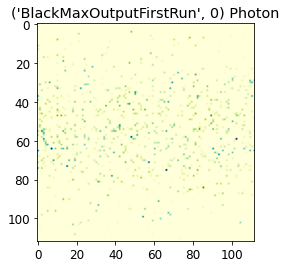

('BlackMaxOutputFirstRun', 1)
1146


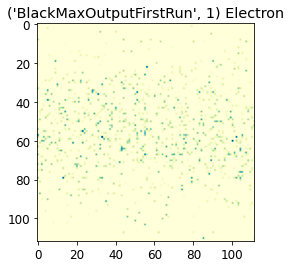

('BlackMaxOutputFirstRun', 2)
1155


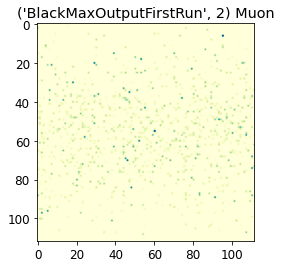

('BlackMaxOutputFirstRun', 3)
1573


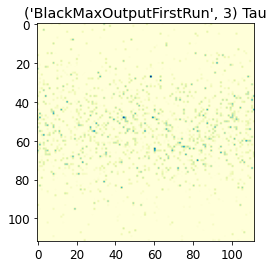

('BlackMaxOutputFirstRun', 4)
11508


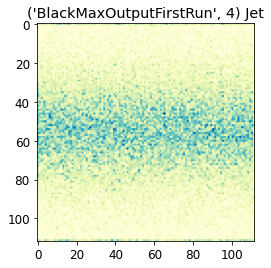

('BlackMaxOutputFirstRun', 6)
112


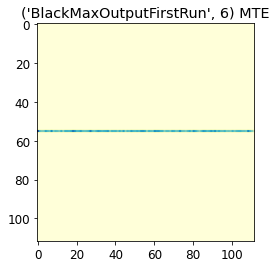

('BlackMaxOutputFirstRun2', 0)
1118


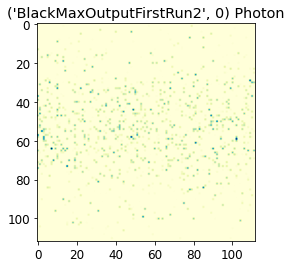

('BlackMaxOutputFirstRun2', 1)
1186


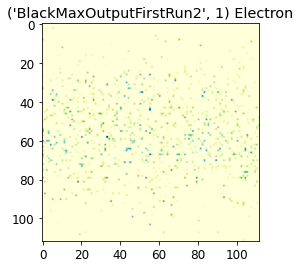

('BlackMaxOutputFirstRun2', 2)
1173


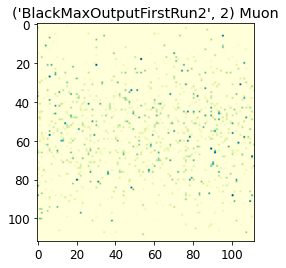

('BlackMaxOutputFirstRun2', 3)
1623


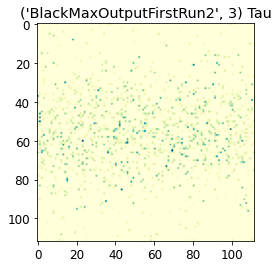

('BlackMaxOutputFirstRun2', 4)
11494


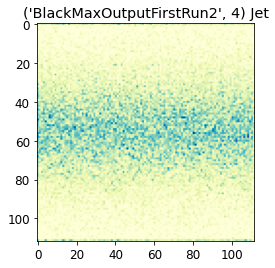

('BlackMaxOutputFirstRun2', 6)
112


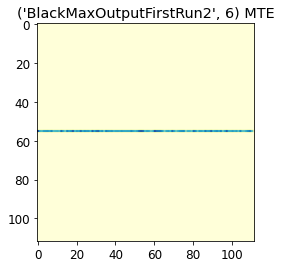

('PP13-Sphaleron-THR9-FRZ15-NB33-71-NSUBP5', 0)
1083


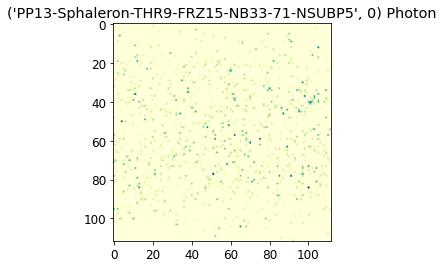

('PP13-Sphaleron-THR9-FRZ15-NB33-71-NSUBP5', 1)
720


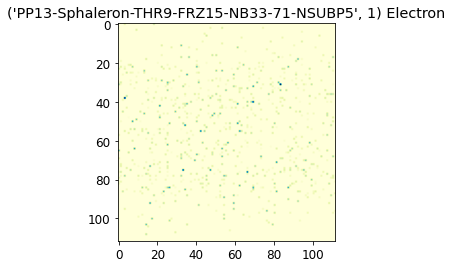

('PP13-Sphaleron-THR9-FRZ15-NB33-71-NSUBP5', 2)
510


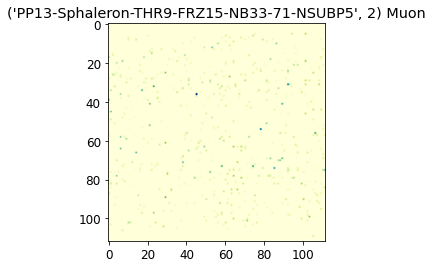

('PP13-Sphaleron-THR9-FRZ15-NB33-71-NSUBP5', 3)
1709


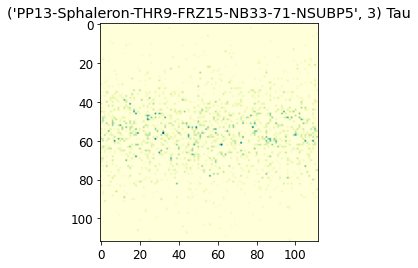

('PP13-Sphaleron-THR9-FRZ15-NB33-71-NSUBP5', 4)
8839


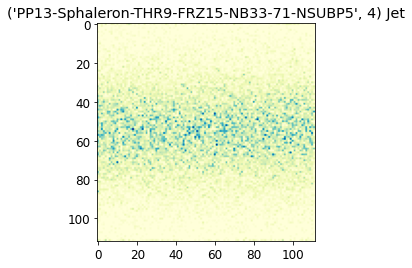

('PP13-Sphaleron-THR9-FRZ15-NB33-71-NSUBP5', 6)
112


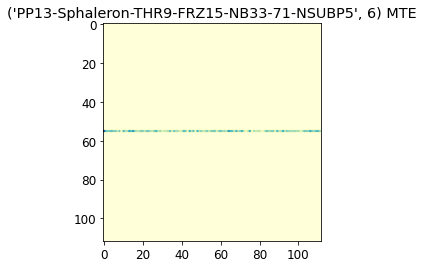

In [29]:
imageHeight = 112
imageWidth = 112
def createAllImages(imageHeight, imageWidth):
  images = {}
  eta2D = [getAllEtas(dataSet) for dataSet in dataSets]
  maxEta = 2.5 #*max(standardDeviance2D(eta2D))
  minEta = -2.5 #*max(standardDeviance2D(eta2D))
  maxPhi = 3.14
  minPhi = -3.14

  for dataSet in dataSets:
    (objTypeToMaxVal, binnedImages) = createEtaPhiBinnedImages(dataSet, imageHeight, imageWidth, maxEta, minEta, maxPhi, minPhi)
    normalizedImages = normalizeEnergyImages(objTypeToMaxVal, binnedImages)
    images.update(normalizedImages)
  return images

def mergeImagesByObjectTypeAndPlot(images, imageHeight, imageWidth):
  objectImages = {} # map fra (filename, objectType) til map fra (x, y) til energi
  for imageKey in images:
    filename, eventNr, objectType = imageKey
    image = images[imageKey]
    currentImageForObj = objectImages.get((filename, objectType), {})
    for coords in image:
      currentImageForObj[(coords)] = image[(coords)] + currentImageForObj.get((coords), 0)
    objectImages[(filename, objectType)] = currentImageForObj
  for imageKey in objectImages:
    filename, objectType = imageKey
    objectTypeHumanReadable = objectMapping[objectType]
    print(imageKey)
    print(len(objectImages[(imageKey)]))
    plt.title(f"{imageKey} {objectTypeHumanReadable}")
    plt.imshow(fillBlanksInImage(objectImages[(imageKey)], imageHeight, imageWidth))
    startEndX = [0, imageWidth-1]
    startEndY = [imageHeight/2, imageWidth/2]
    #plt.plot(startEndX, startEndY)
    plt.show()
    #print(objectImages[(imageKey)])

images = createAllImages(imageHeight, imageWidth)
mergeImagesByObjectTypeAndPlot(images, imageHeight, imageWidth)







In [30]:
mergedImageForDataSet = {}
for dataset in dataSets:
  mergedImages = []
  for idx, data in enumerate(dataset.data):
    electronImage= images.get((dataset.fileName, idx, 1), {})
    muonImage = images.get((dataset.fileName, idx, 2), {})
    jetsImage = images.get((dataset.fileName, idx, 4), {})
    mergedImages.append(mergeImageSparse(electronImage, muonImage, jetsImage))
  print(len(mergedImages))
  print(mergedImages[random.randrange(0, len(mergedImages))])
  mergedImageForDataSet[dataset.fileName] = mergedImages



10000
{(70, 16): (0, 0, 89), (73, 63): (0, 0, 58), (34, 82): (0, 0, 61), (34, 53): (0, 0, 25), (10, 100): (0, 0, 27), (24, 102): (0, 0, 14), (23, 8): (0, 0, 3), (29, 43): (0, 0, 1), (58, 58): (0, 0, 0)}
10000
{(59, 102): (0, 0, 136), (50, 28): (0, 0, 90), (73, 78): (0, 0, 65), (61, 73): (0, 0, 6), (9, 43): (0, 0, 15), (99, 93): (0, 0, 10), (111, 28): (0, 0, 17), (62, 90): (0, 0, 2), (76, 41): (0, 0, 1)}
1000
{(85, 105): (19, 0, 0), (49, 110): (0, 0, 126), (48, 76): (0, 0, 115), (54, 37): (0, 0, 84), (48, 63): (0, 0, 83), (57, 8): (0, 0, 69), (61, 91): (0, 0, 63), (53, 22): (0, 0, 53), (38, 54): (0, 0, 60), (42, 91): (0, 0, 42), (25, 63): (0, 0, 48), (66, 41): (0, 0, 27), (62, 70): (0, 0, 18), (80, 6): (0, 0, 29), (41, 45): (0, 0, 18), (64, 106): (0, 0, 13), (31, 87): (0, 0, 14), (25, 26): (0, 0, 15), (37, 19): (0, 0, 9), (37, 103): (0, 0, 8), (96, 67): (0, 0, 20), (26, 10): (0, 0, 11), (73, 93): (0, 0, 7), (79, 80): (0, 0, 7), (63, 58): (0, 0, 4), (75, 66): (0, 0, 4)}


In [31]:

mergedTensor = torch.empty((imageHeight,imageWidth, 3), dtype=torch.int32)
tensors = []
for dataset in dataSets:
  label = paths.index(dataset.path)
  for image in itertools.islice(mergedImageForDataSet[dataset.fileName], 0, 500):
    indexes = [[0,0]]
    values = [[label, 0, 0]]
    for key in image:
      x, y = key
      indexes.append([x, y])
      value = image[key]
      values.append(list(value))
    s = torch.sparse_coo_tensor(torch.tensor(indexes).t(), values, (imageHeight, imageWidth, 3)).to_dense()
    tensors.append(s)

mergedTensor = torch.stack(tensors)
tensors = []

In [32]:
def get_x(r): return TensorImage([r[:,:,0],r[:,:,1],r[:,:,2]]) # make 3 copies of detector information to get 3-layer image.
def get_y(r): return int(r[0,0,0])
dblock = DataBlock( blocks = (ImageBlock, CategoryBlock),
                    get_x = get_x, 
                    get_y = get_y,
                    splitter = RandomSplitter(valid_pct=0.5, seed=41),
                  )


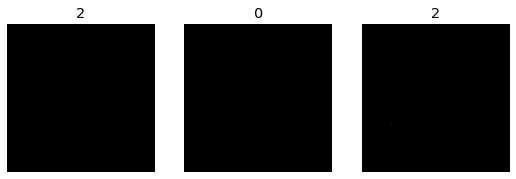

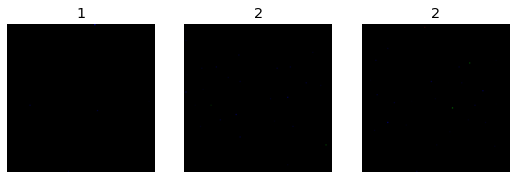

In [33]:
dls = dblock.dataloaders(mergedTensor)
dls.train.show_batch(max_n=3)
dls.valid.show_batch(max_n=3)

In [34]:
dls.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.0003981071640737355)

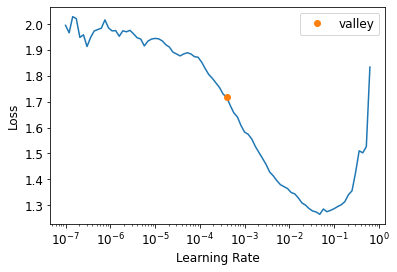

In [35]:
learn = cnn_learner(dls, resnet18, metrics=error_rate).to_fp16()
learn.lr_find()

In [36]:
learn.fine_tune(10, base_lr=1e-3, wd=0.7)

epoch,train_loss,valid_loss,error_rate,time
0,1.394293,2.265582,0.660000,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.748791,1.092039,0.550667,00:10
1,0.744922,0.954540,0.398667,00:10
2,0.701130,0.716145,0.381333,00:10
3,0.636979,0.816875,0.346667,00:10
4,0.583355,0.914176,0.358667,00:10
5,0.532640,1.040641,0.424000,00:10
6,0.493237,1.224944,0.468000,00:10
7,0.451684,1.331013,0.477333,00:12
8,0.423984,1.364910,0.485333,00:10
9,0.388240,1.371553,0.478667,00:10


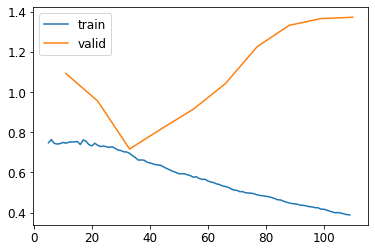

In [37]:
learn.recorder.plot_loss()

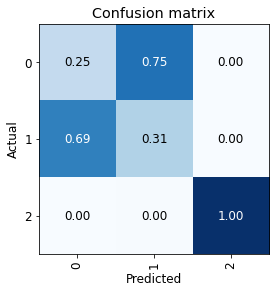

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True)

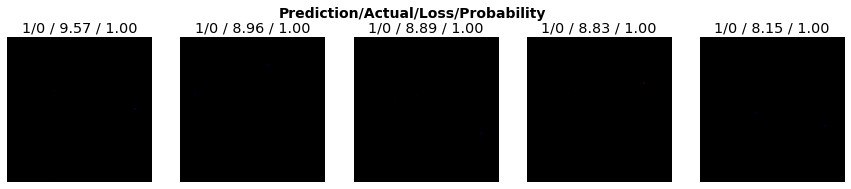

In [39]:
interp.plot_top_losses(5, nrows=1)